# Week 12: U-Net
## Convolutional Networks for Image Segmentation

Olaf Ronneberger, Philipp Fischer, and Thomas Brox
2015

U-Net is a segmentation network whose architecture resembles the letter "u". The network "contracts to capture context and a symmetric expanding path that enables precise localization" (Ronnenberger et al. 2015).

![unet.PNG](unet.PNG)

The example provided here will use a dataset of images we chose to use is labeled to classify cars. There are two labels in these images ('car' and 'not car'). 


## Weighted Mask

The use of the standard categorical cross-entropy loss function in U-net can be problematic for biomedical image segmentation:  
* When using this loss function, the model is rewarded for classifying narrow cell boundaries as being in-cell pixels because they are close to many other in-cell pixels  
* While this might not reduce the overall accuracy much, it reduces the usefulness of the segmentation result  
* To mitigate this problem, the implementation from the paper includes a weight map that is used to add a weight value to the loss function.  

This weight map is calculated as follows:

$$\Large
w(x) = w_c(x) + w_0\ \cdot\ exp\ (-\ \frac{(d_1(x) + d_2(x))^2}{2 \sigma^2})
$$

$$\small  
x\ is\ the\ current\ pixel \\  
w_c\ is\ the\ class\ weighting\ that\ upweights\ classes\ differently \\  
d_1\ is\ the\ distance\ to\ the\ nearest\ cell\ boundary \\  
d_2\ is\ the\ distance\ to\ the\ second\ nearest\ cell\ boundary \\  
w_0\ and\ \sigma\ are\ constants\ that\ scale\ the\ weighting $$  
  
### Example:  
Let's implement this in code. First we need to develop a function that can generate random cells to simulate a microscopy image:


In [19]:
# from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_random_circles(n = 50, d = 100, cell_size = 20):

  """
  Generate a numpy array that is a simulated mask for an image of 
  cells where the in-cell pixels are 1 and background pixels are 0. 
  Used as prelimiary generator for unet_weight_map function.

  Parameters
  ----------
  n:  int
      Number of cells to be created
  d:  int
      Dictionary of weight classes.
  Returns
  -------
  Numpy array
      Simulated mask for a cell-image. A 2D array of shape (d,d).
  """
  # Generate coordinates for random circles
  circles = np.random.randint(0, d, (n, 3))
  # Ensure radius (3rd col) is between d/3 and d
  circles[:,2] = np.interp(circles[:,2], (circles[:,2].max(), circles[:,2].max()), (d/3,d))

  # Generate background for simluated cell image 
  x = np.zeros((d, d), dtype=int)
  
  # Iterate over circles and insert into simulated image
  for x0, y0, r in circles:
    copy_x = deepcopy(x)
    # Generate new 2D array with circle of pixels with value 1 for current circle
    new_x = np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*cell_size)**2, x.shape)
    
    # Add new circle to cell map
    for i in range(1,len(new_x)-1):
      for j in range(1,len(new_x[0])-1):
        # Only add to cell map if neighbours are 0
        if new_x[i][j] == True and x[i-1][j]==0 and x[i-1][j-1]==0 and x[i][j-1]==0 and x[i][j+1]==0 and x[i+1][j+1]==0 and x[i+1][j]==0 and x[i+1][j-1]==0 and x[i-1][j+1]==0:
          copy_x[i][j] += new_x[i][j]
    x += copy_x
  
  # Clip values above 1 to a max of 1
  x = np.clip(x, 0, 1)

  # Return simulated cell map
  return x

Second we need to implement the weighting function that weights each pixel in the image based on it's distance to the nearest cell boundaries:

In [3]:

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

  """
  Generate weight maps as specified in the U-Net paper
  for boolean mask.
  
  "U-Net: Convolutional Networks for Biomedical Image Segmentation"
  https://arxiv.org/pdf/1505.04597.pdf
  
  Parameters
  ----------
  mask: Numpy array
      2D array of shape (image_height, image_width) representing binary mask
      of objects.
  wc: dict
      Dictionary of weight classes.
  w0: int
      Border weight parameter.
  sigma: int
      Border width parameter.
  Returns
  -------
  Numpy array
      Training weights. A 2D array of shape (image_height, image_width).
  """
  
  # Grab labels from input
  labels = label(y)
  no_labels = labels == 0
  label_ids = sorted(np.unique(labels))[1:]

  # Check for circles in y
  if len(label_ids) > 1:
    # Calculate distances
    distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))
    for i, label_id in enumerate(label_ids):
      distances[:,:,i] = distance_transform_edt(labels != label_id)

    # Sort for nearest cell boundary distances
    distances = np.sort(distances, axis=2)
    d1 = distances[:,:,0]
    d2 = distances[:,:,1]
    
    # Calculate second term in weighting equation
    w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

    # Sum with class weights to produce weighted mask
    if wc:
      class_weights = np.zeros_like(y)
      for k, v in wc.items():
        class_weights[y == k] = v
      w = w + class_weights
  
  # If no circles we passed in to the function, return zeros
  else:
    w = np.zeros_like(y)
  
  # Return weighted mask
  return w


Let's generate a simulated cell image mask and then weight the pixels of that mask. You need to choose weighting values for the two classes, cell and non-cell:

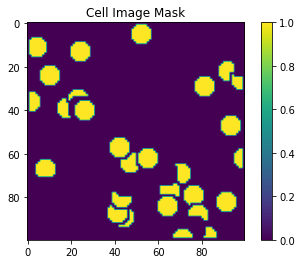

Class Weighting: {0: 0, 1: 0}


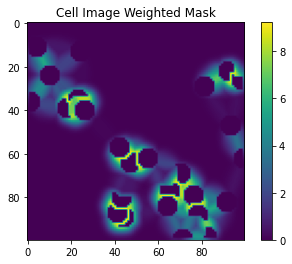

In [4]:
# Generate simulated cell mask 
num_cells        = 60
image_dimensions = 100
cell_size        = 15
y = generate_random_circles(num_cells, image_dimensions, cell_size)

# Display cell mask
plt.imshow(y)
plt.title('Cell Image Mask')
plt.colorbar()
plt.show()

# Weighting for pixels assigned to the two classes
class_weighting = {
  # TODO: Choose weighting values for the classes in the cell mask - they are currently set to 0.
  0: 0, # background
  1: 0  # cells
}

print('Class Weighting:', class_weighting)

# Generate weighted map
w = unet_weight_map(y, class_weighting)

# Display weighted mask
plt.imshow(w)
plt.title('Cell Image Weighted Mask')
plt.colorbar()
plt.show()

Try adjusting the weighting of the class in the class_weighting dictionary (or other parameters) and see what impact that has on the final weighted mask.

# Implementing U-Net

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

We use the double convolution quite a lot in this architecture so let's implement it as a reusable code block.

In [6]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),  # 3x3 convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


Now let's devise the network using Pytorch functionality.

In [7]:

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

For a sanity check, let's just make sure that we are getting a prediction that is the shape we would expect.

**QUESTION: Given the shape of the torch.randn() and the fact that we're using padding, what do you expect the output shape to be?**


In [8]:
x = torch.randn((3, 1, 50, 50))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
assert preds.shape == x.shape


### Dataset Loader
Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches”.

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Useful Utility Functions

In [55]:
import torch
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x
            y = y.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images"
):
    
    model.eval()
    for idx, (x, y) in enumerate(loader):
        imageName = os.path.join(folder, f"pred_{idx}.png")
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, imageName
        )
#         torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

### Training Function

In [11]:
def train_fn(loader, model, optimizer, loss_fn):

    for batch_idx, (data, targets) in enumerate(loader):

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets.float().unsqueeze(1))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Iter: {batch_idx}/{len(loader.dataset)}, Loss: {loss.item():.04f}")


### Hyperparameters
Choose hyperparameters for the model. Experiment with the learning rate and batch size.

In [40]:
print(os.getcwd().replace("\\","/"))

C:/Users/Gina/OneDrive/Documents/GradWork_Spring2022/DeepLearning/uNet/UNET_WORKING/uNet


In [49]:
# Hyperparameters

# TODO: choose values
LEARNING_RATE = 1e-4
BATCH_SIZE = 1

IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
LOAD_MODEL = False

cwd = os.getcwd() #.replace("\\","/")

TRAIN_IMG_DIR = os.path.join(cwd, "data_small", "train_images")
TRAIN_MASK_DIR = os.path.join(cwd, "data_small", "train_masks")
VAL_IMG_DIR = os.path.join(cwd, "data_small", "val_images")
VAL_MASK_DIR = os.path.join(cwd, "data_small", "val_masks")

### Data Transformation
The images in this dataset are quite large, so we will need to reduce the size in order to make the training time a little more reasonable. While this might sacrifice some accuracy due to compression, we can run more data through the model during training this way.

In [42]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)


### Training the Model

In [43]:
model = UNET(in_channels=3, out_channels=1)

# TODO: choose a loss function
loss_fn = nn.BCEWithLogitsLoss()

# TODO: implement an optimizer for this model
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(train_loader, model, optimizer, loss_fn)


Iter: 0/48, Loss: 0.5804
Iter: 1/48, Loss: 0.5043
Iter: 2/48, Loss: 0.4553
Iter: 3/48, Loss: 0.4145
Iter: 4/48, Loss: 0.5170
Iter: 5/48, Loss: 0.3645
Iter: 6/48, Loss: 0.4483
Iter: 7/48, Loss: 0.3376
Iter: 8/48, Loss: 0.3339
Iter: 9/48, Loss: 0.3397
Iter: 10/48, Loss: 0.2906
Iter: 11/48, Loss: 0.2992
Iter: 12/48, Loss: 0.2755
Iter: 13/48, Loss: 0.2889
Iter: 14/48, Loss: 0.3767
Iter: 15/48, Loss: 0.2637
Iter: 16/48, Loss: 0.2459
Iter: 17/48, Loss: 0.3011
Iter: 18/48, Loss: 0.2805
Iter: 19/48, Loss: 0.2333
Iter: 20/48, Loss: 0.3021
Iter: 21/48, Loss: 0.2664
Iter: 22/48, Loss: 0.2315
Iter: 23/48, Loss: 0.2308
Iter: 24/48, Loss: 0.2283
Iter: 25/48, Loss: 0.2179
Iter: 26/48, Loss: 0.2163
Iter: 27/48, Loss: 0.2786
Iter: 28/48, Loss: 0.2304
Iter: 29/48, Loss: 0.2115
Iter: 30/48, Loss: 0.2404
Iter: 31/48, Loss: 0.2053
Iter: 32/48, Loss: 0.2136
Iter: 33/48, Loss: 0.2046
Iter: 34/48, Loss: 0.2211
Iter: 35/48, Loss: 0.1975
Iter: 36/48, Loss: 0.1998
Iter: 37/48, Loss: 0.1962
Iter: 38/48, Loss: 0.2

### Validating the Model

In [56]:
# check accuracy
check_accuracy(val_loader, model)

# print some examples to a folder
folder = os.path.join(cwd, "saved_images")
if not os.path.exists(folder):
    os.mkdir(folder)

print(folder)

save_predictions_as_imgs(
    val_loader, model, folder = folder
)

Got 604809/614400 with acc 98.44
C:\Users\Gina\OneDrive\Documents\GradWork_Spring2022\DeepLearning\uNet\UNET_WORKING\uNet\saved_images
